# 🧪 Simulation Tutorial

This tutorial demonstrates how to simulate synthetic panel data with known structural patterns and shocks, and then apply `OptimalPanel` to forecast outcomes for a target unit.

## ⚙️ Simulation Details

We simulate panel data for **3 units** (A, B, C) from **1980 to 2024**, each with an outcome variable `y` and three predictors: x1, x2, x3.
+ **x1**: A global trend shared across all units (e.g., a slowly drifting macro variable).
+ **x2**: A temporary outbreak signal that is **predictive only for Unit C** — simulates covariate relevance heterogeneity.
+ **x3**: A unit-specific AR(1) process.

The outcome variable y evolves as an AR(1) process influenced by these predictors and **idiosyncratic shocks**:
+ **Unit A**: Experiences a sudden persistent shock from 2015 to 2020.
+ **Unit C**: Gets a shock from 2005 to 2010 that aligns with the predictive outbreak signal x2.

In [1]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Simulation settings
years = np.arange(1980, 2025)
n_years = len(years)
units = ['A', 'B', 'C']
rho = 0.8  # AR coefficient
sigma_eps = 0.5
phi = 0.5  # AR(1) for x3
beta = np.array([0.5, 1.0, -0.5])  # Coefficients for x1, x2, x3

# Initialize data containers
data = []

# Simulate common x1 trend
x1 = np.zeros(n_years)
x1[0] = np.random.normal()
for t in range(1, n_years):
    x1[t] = x1[t - 1] + np.random.normal(scale=0.3)

# Simulate outbreak signal for x2 (predictive only for unit C)
signal = np.zeros(n_years)
signal_start = np.where(years == 2003)[0][0]
signal_peak = np.where(years == 2005)[0][0]
signal_end = np.where(years == 2010)[0][0]
signal[signal_start:signal_peak] = np.linspace(0, 1, signal_peak - signal_start)
signal[signal_peak:signal_end] = np.linspace(1, 0, signal_end - signal_peak)

# Simulate data for each unit
for unit in units:
    alpha = np.random.normal()
    y = np.zeros(n_years)
    y_lag = np.zeros(n_years)
    x2 = np.zeros(n_years)
    x3 = np.zeros(n_years)
    eps = np.random.normal(scale=sigma_eps, size=n_years)
    zeta = np.random.normal(scale=0.3, size=n_years)
    xi = np.random.normal(scale=0.2, size=n_years)

    x3[0] = np.random.normal()
    for t in range(1, n_years):
        x3[t] = phi * x3[t - 1] + zeta[t]

    # Assign x2 based on whether unit is predictive
    if unit == 'C':
        gamma = 1.0
    else:
        gamma = 0.0
    x2 = gamma * signal + xi

    # Initialize y[0]
    y[0] = alpha + beta @ np.array([x1[0], x2[0], x3[0]]) + eps[0]
    y_lag[0] = np.nan  # no lag at t=0

    for t in range(1, n_years):
        # Apply outbreak shocks
        delta = 0
        if unit == 'A' and 2015 <= years[t] <= 2020:
            delta = 3
        elif unit == 'C' and 2005 <= years[t] <= 2010:
            delta = 3

        y[t] = (
            alpha
            + rho * y[t - 1]
            + beta @ np.array([x1[t], x2[t], x3[t]])
            + delta
            + eps[t]
        )
        y_lag[t] = y[t - 1]

        data.append({
            'unit': unit,
            'year': years[t],
            'y': y[t],
            'y_lag': y_lag[t],
            'x1': x1[t],
            'x2': x2[t],
            'x3': x3[t],
            'delta': delta
        })

# Create DataFrame
df_sim = pd.DataFrame(data)
df_sim['year'] = pd.to_datetime(df_sim['year'], format='%Y')
df_sim

,unit,year,y,y_lag,x1,x2,x3,delta
0,A,1981-01-01,-0.052383,-0.429878,0.455235,-0.064412,-0.639195,0
1,A,1982-01-01,0.106480,-0.052383,0.649541,0.162703,-0.417896,0
2,A,1983-01-01,-1.045837,0.106480,1.106450,-0.246173,-0.326580,0
3,A,1984-01-01,-0.529706,-1.045837,1.036204,0.045492,-0.602345,0
4,A,1985-01-01,-0.485572,-0.529706,0.965963,0.261429,-0.212336,0
...,...,...,...,...,...,...,...,...
127,C,2020-01-01,-4.179262,-4.021869,-2.054402,-0.012536,0.103119,0
128,C,2021-01-01,-3.383287,-4.179262,-2.002992,0.191028,-0.268726,0
129,C,2022-01-01,-4.018603,-3.383287,-2.037686,-0.197145,-0.177077,0
130,C,2023-01-01,-4.081144,-4.018603,-2.128017,0.100809,-0.052450,0


### A plot of `y` by unit reveals these patterns visually:

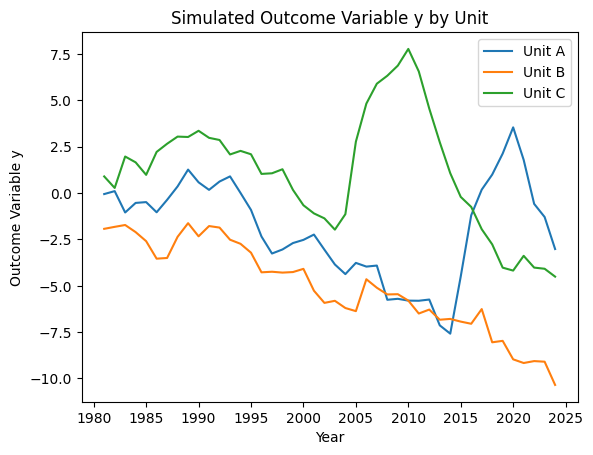

In [2]:
# Plot "y" for each unit
import matplotlib.pyplot as plt
for unit in units:
    subset = df_sim[df_sim['unit'] == unit]
    plt.plot(subset['year'], subset['y'], label=f'Unit {unit}')
plt.title('Simulated Outcome Variable y by Unit')
plt.xlabel('Year')
plt.ylabel('Outcome Variable y')
plt.legend()
plt.show()

## 🎯 Applying OptimalPanel

Once the panel is simulated, we initialize and prepare the **RL optimizer**:

In [3]:
from OptimalPanel.optimizer import OptimalBundleRL

total_epochs = 1500
forecast_times = list(pd.date_range(start="2010-01-01", end="2024-01-01", freq="YS"))
    
rl = OptimalBundleRL(
    df=df_sim,
    unit_col='unit',
    time_col='year',
    target_col='y',
    feature_cols=['y_lag', 'x1', 'x2', 'x3'],
    target_unit='A',
    forecast_times=forecast_times
)

This sets up a **forecasting task for Unit A**, where the policy will explore donor units (B and C) to improve predictions during the 2010–2024 period, while avoiding poor generalization from shock periods.

In [4]:
# Initial similarity vector
rl.compute_similarities(
    test_start=pd.to_datetime("1998-01-01"),
    test_end=pd.to_datetime("2009-01-01")
)


🔍 Target: A — Top donor scores:
  B: 0.4848
  C: 0.1516


(tensor([0.4848, 0.1516]), ['B', 'C'])

In [5]:
rl.train(n_epochs=total_epochs, save=False)
rl.print_top_bundles(top_k=2)

Epoch 0 — Avg MSE: 3.5271, Bundle Size: 1
Epoch 10 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 30 — Avg MSE: 3.0669, Bundle Size: 1
Epoch 40 — Avg MSE: 3.0669, Bundle Size: 1
Epoch 50 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 60 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 80 — Avg MSE: 3.5271, Bundle Size: 1
Epoch 90 — Avg MSE: 3.0669, Bundle Size: 1
Epoch 100 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 120 — Avg MSE: 3.5271, Bundle Size: 1
Epoch 130 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 140 — Avg MSE: 3.5271, Bundle Size: 1
Epoch 150 — Avg MSE: 3.5271, Bundle Size: 1
Epoch 160 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 170 — Avg MSE: 3.0669, Bundle Size: 1
Epoch 180 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 190 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 200 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 210 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 220 — Avg MSE: 3.5271, Bundle Size: 1
Epoch 230 — Avg MSE: 2.6861, Bundle Size: 2
Epoch 240 — Avg MSE: 3.0669, Bundle Size: 1
Epoch 250 — Avg MSE: 2.6861, Bundle Size:

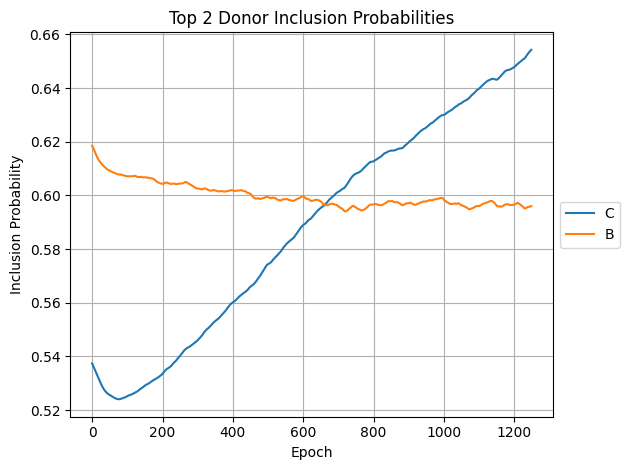

In [7]:
rl.plot_donor_probs(top_n=2)

+ When rolling window includes `A`'s outbreak (2015-2020), `C` becomes informative. 
+ When rolling window excludes `A`’s outbreak, RL algorithm may penalize including `C`.